In [5]:
import pandas as pd
import matplotlib.pyplot as plt

CO2E_PATH = r"D:\UWE CLASS\CSCT master\Master_project\Data\region_year_co2e.csv"
BREAKDOWN_PATH = r"D:\UWE CLASS\CSCT master\Master_project\Data\region_year_vehicle_co2e_breakdown.csv"

co2e = pd.read_csv(CO2E_PATH)
bd = pd.read_csv(BREAKDOWN_PATH)

co2e.head(), bd.head()


(     region_name  year  co2e_tonnes_total
 0  East Midlands  2015       9.237719e+06
 1  East Midlands  2016       9.515900e+06
 2  East Midlands  2017       9.671759e+06
 3  East Midlands  2018       9.750602e+06
 4  East Midlands  2019       9.921433e+06,
      region_name  year vehicle_std  activity_km  share_activity   co2e_tonnes
 0     South West  2015  motorcycle  589501242.0        0.011036  51697.785170
 1  East Midlands  2015  motorcycle  341662882.0        0.007741  29962.980594
 2       Scotland  2015  motorcycle  284692246.0        0.006320  24966.798244
 3          Wales  2015  motorcycle  222571722.0        0.007745  19518.983590
 4     North West  2015  motorcycle  355181338.0        0.006299  31148.515389)

In [6]:
print("co2e shape:", co2e.shape, "years:", co2e.year.min(), "-", co2e.year.max())
print("bd shape:", bd.shape, "vehicles:", bd.vehicle_std.unique())


co2e shape: (110, 3) years: 2015 - 2024
bd shape: (550, 6) vehicles: ['motorcycle' 'car' 'bus' 'lgv' 'hgv']


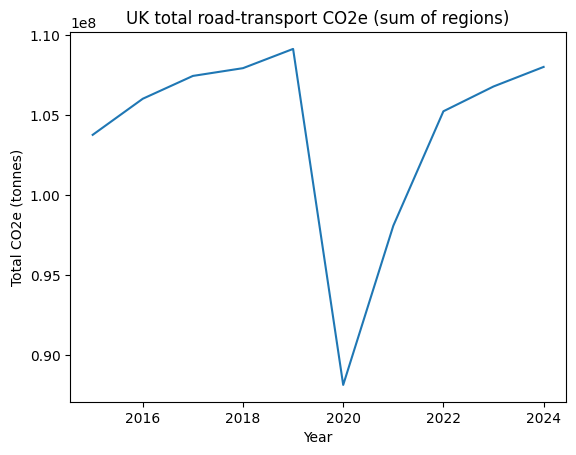

,year,co2e_tonnes_total
0,2015,1.037690e+08
1,2016,1.060252e+08
2,2017,1.074507e+08
3,2018,1.079359e+08
4,2019,1.091377e+08


In [7]:
uk = co2e.groupby("year", as_index=False)["co2e_tonnes_total"].sum()

plt.figure()
plt.plot(uk["year"], uk["co2e_tonnes_total"])
plt.xlabel("Year")
plt.ylabel("Total CO2e (tonnes)")
plt.title("UK total road-transport CO2e (sum of regions)")
plt.show()

uk.head()


In [8]:
latest = co2e["year"].max()
top5 = co2e[co2e["year"]==latest].sort_values("co2e_tonnes_total", ascending=False).head(5)
top5


,region_name,year,co2e_tonnes_total
69,South East,2024,1.689299e+07
19,East of England,2024,1.248723e+07
49,North West,2024,1.179281e+07
79,South West,2024,1.094261e+07
99,West Midlands,2024,1.079868e+07


In [9]:
base = co2e[co2e["year"]==2015].set_index("region_name")["co2e_tonnes_total"]
last = co2e[co2e["year"]==2024].set_index("region_name")["co2e_tonnes_total"]

chg = ((last - base) / base * 100).rename("pct_change_2015_2024").reset_index()
chg_sorted = chg.sort_values("pct_change_2015_2024", ascending=False)

chg_sorted.head(5), chg_sorted.tail(5)




(       region_name  pct_change_2015_2024
 3       North East             10.668926
 0    East Midlands              8.402926
 5         Scotland              7.136945
 1  East of England              6.247790
 7       South West              4.654175,
                  region_name  pct_change_2015_2024
 8                      Wales              4.175123
 10  Yorkshire and the Humber              3.735891
 4                 North West              3.540784
 6                 South East              0.041143
 2                     London             -3.740753)

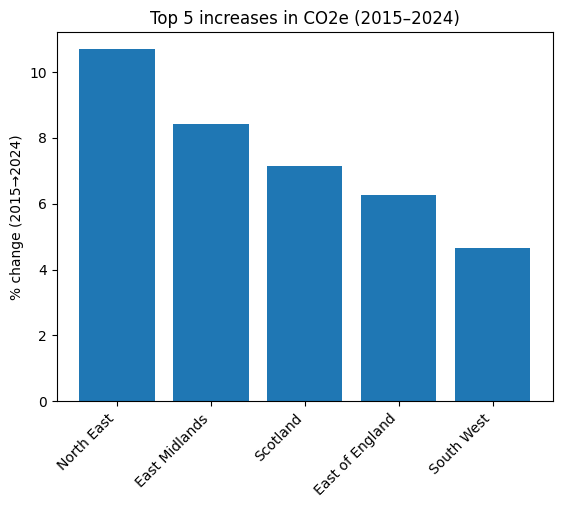

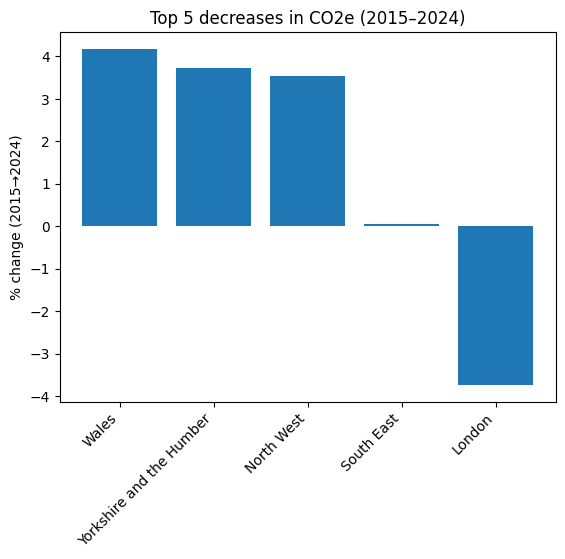

In [10]:
top = chg_sorted.head(5)
bot = chg_sorted.tail(5)

plt.figure()
plt.bar(top["region_name"], top["pct_change_2015_2024"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("% change (2015→2024)")
plt.title("Top 5 increases in CO2e (2015–2024)")
plt.show()

plt.figure()
plt.bar(bot["region_name"], bot["pct_change_2015_2024"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("% change (2015→2024)")
plt.title("Top 5 decreases in CO2e (2015–2024)")
plt.show()


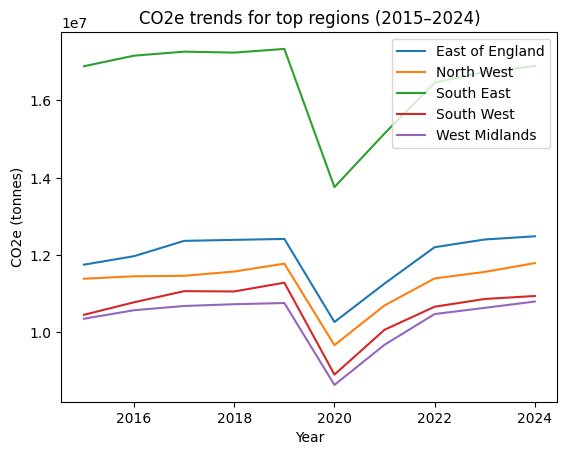

In [11]:
top_regions = top5["region_name"].tolist()

pivot = co2e[co2e["region_name"].isin(top_regions)].pivot(
    index="year", columns="region_name", values="co2e_tonnes_total"
)

plt.figure()
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=col)

plt.xlabel("Year")
plt.ylabel("CO2e (tonnes)")
plt.title("CO2e trends for top regions (2015–2024)")
plt.legend()
plt.show()


In [12]:
bd_2024 = bd[bd["year"]==2024].copy()

mix = (bd_2024.groupby(["region_name","vehicle_std"], as_index=False)["co2e_tonnes"]
       .sum())

mix_total = mix.groupby("region_name", as_index=False)["co2e_tonnes"].sum().rename(columns={"co2e_tonnes":"total"})
mix = mix.merge(mix_total, on="region_name", how="left")
mix["share_emissions"] = mix["co2e_tonnes"] / mix["total"]

mix.head()


,region_name,vehicle_std,co2e_tonnes,total,share_emissions
0,East Midlands,bus,1.684366e+05,1.001396e+07,0.016820
1,East Midlands,car,6.028095e+06,1.001396e+07,0.601969
2,East Midlands,hgv,2.172871e+06,1.001396e+07,0.216984
3,East Midlands,lgv,1.616920e+06,1.001396e+07,0.161467
4,East Midlands,motorcycle,2.763425e+04,1.001396e+07,0.002760


In [13]:
mix_top5 = mix[mix["region_name"].isin(top_regions)].copy()

pivot_mix = mix_top5.pivot(index="region_name", columns="vehicle_std", values="share_emissions").fillna(0)

pivot_mix


vehicle_std,bus,car,hgv,lgv,motorcycle
region_name,,,,,
East of England,0.011144,0.617842,0.186163,0.181442,0.003409
North West,0.011533,0.651198,0.168605,0.166514,0.002149
South East,0.010283,0.657237,0.149450,0.179372,0.003658
South West,0.013246,0.662145,0.131926,0.188501,0.004183
West Midlands,0.009694,0.621191,0.201670,0.165244,0.002201


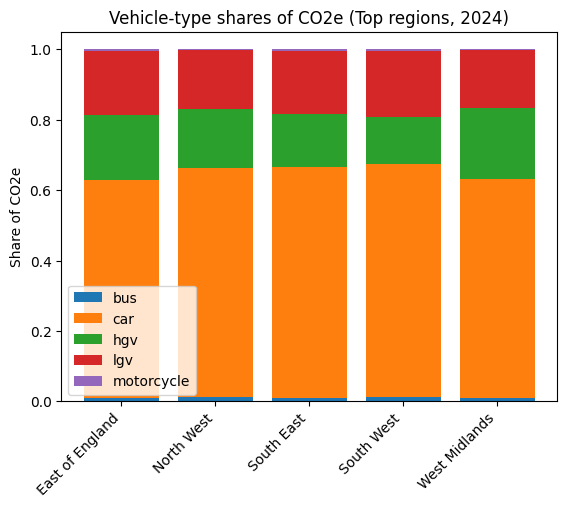

In [14]:
plt.figure()
bottom = None
for v in pivot_mix.columns:
    if bottom is None:
        plt.bar(pivot_mix.index, pivot_mix[v], label=v)
        bottom = pivot_mix[v].values
    else:
        plt.bar(pivot_mix.index, pivot_mix[v], bottom=bottom, label=v)
        bottom = bottom + pivot_mix[v].values

plt.xticks(rotation=45, ha="right")
plt.ylabel("Share of CO2e")
plt.title("Vehicle-type shares of CO2e (Top regions, 2024)")
plt.legend()
plt.show()


In [15]:
uk_2024 = co2e[co2e["year"]==2024].copy()
uk_total_2024 = uk_2024["co2e_tonnes_total"].sum()

uk_2024["share_uk_2024"] = uk_2024["co2e_tonnes_total"] / uk_total_2024
uk_2024.sort_values("share_uk_2024", ascending=False).head(10)


,region_name,year,co2e_tonnes_total,share_uk_2024
69,South East,2024,1.689299e+07,0.156398
19,East of England,2024,1.248723e+07,0.115609
49,North West,2024,1.179281e+07,0.109180
79,South West,2024,1.094261e+07,0.101309
99,West Midlands,2024,1.079868e+07,0.099976
9,East Midlands,2024,1.001396e+07,0.092711
59,Scotland,2024,9.895866e+06,0.091618
109,Yorkshire and the Humber,2024,9.432647e+06,0.087329
29,London,2024,5.900242e+06,0.054626
89,Wales,2024,5.820192e+06,0.053884


In [16]:
import os

OUT_DIR = r"D:\UWE CLASS\CSCT master\Master_project\Outputs\EDA"
os.makedirs(OUT_DIR, exist_ok=True)
print("Output folder:", OUT_DIR)


Output folder: D:\UWE CLASS\CSCT master\Master_project\Outputs\EDA


In [19]:
chg_sorted.to_csv(os.path.join(OUT_DIR, "pct_change_2015_2024_by_region.csv"), index=False)

top5.to_csv(os.path.join(OUT_DIR, f"top5_regions_{latest}.csv"), index=False)

pivot_mix.reset_index().to_csv(os.path.join(OUT_DIR, "vehicle_share_top_regions_2024.csv"), index=False)

uk_2024.sort_values("share_uk_2024", ascending=False).to_csv(
    os.path.join(OUT_DIR, "region_share_of_uk_total_2024.csv"),
    index=False
)


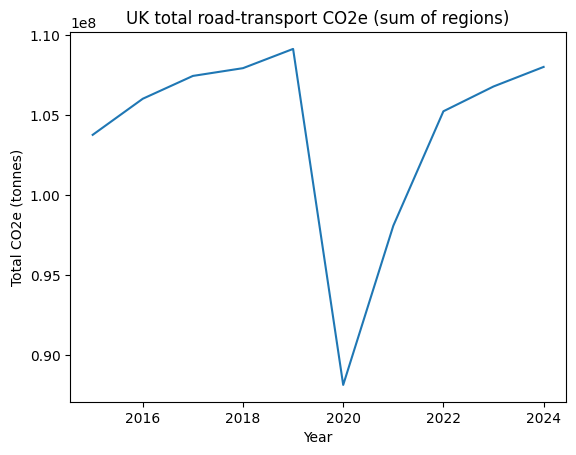

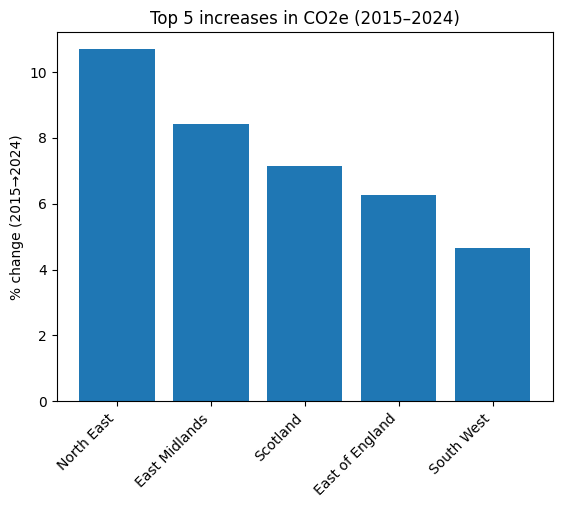

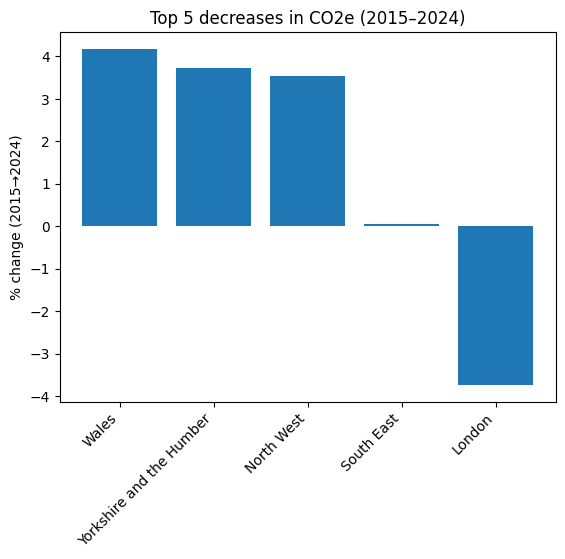

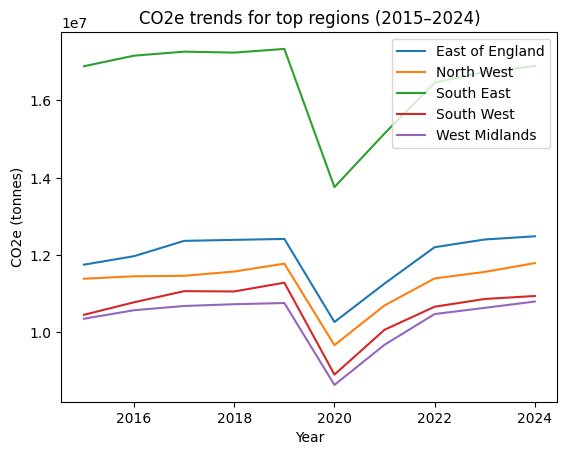

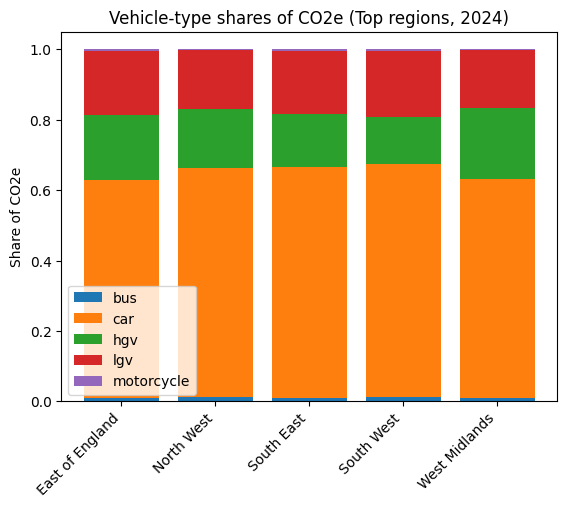

In [20]:
plt.figure()
plt.plot(uk["year"], uk["co2e_tonnes_total"])
plt.xlabel("Year")
plt.ylabel("Total CO2e (tonnes)")
plt.title("UK total road-transport CO2e (sum of regions)")
plt.savefig(os.path.join(OUT_DIR, "uk_total_trend_2015_2024.png"), dpi=300, bbox_inches="tight")
plt.show()

# increases
plt.figure()
plt.bar(top["region_name"], top["pct_change_2015_2024"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("% change (2015→2024)")
plt.title("Top 5 increases in CO2e (2015–2024)")
plt.savefig(os.path.join(OUT_DIR, "top5_increases_pct_change.png"), dpi=300, bbox_inches="tight")
plt.show()

# decreases
plt.figure()
plt.bar(bot["region_name"], bot["pct_change_2015_2024"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("% change (2015→2024)")
plt.title("Top 5 decreases in CO2e (2015–2024)")
plt.savefig(os.path.join(OUT_DIR, "top5_decreases_pct_change.png"), dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], label=col)
plt.xlabel("Year")
plt.ylabel("CO2e (tonnes)")
plt.title("CO2e trends for top regions (2015–2024)")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "top_regions_trend_lines.png"), dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
bottom = None
for v in pivot_mix.columns:
    if bottom is None:
        plt.bar(pivot_mix.index, pivot_mix[v], label=v)
        bottom = pivot_mix[v].values
    else:
        plt.bar(pivot_mix.index, pivot_mix[v], bottom=bottom, label=v)
        bottom = bottom + pivot_mix[v].values

plt.xticks(rotation=45, ha="right")
plt.ylabel("Share of CO2e")
plt.title("Vehicle-type shares of CO2e (Top regions, 2024)")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "vehicle_share_stacked_top_regions_2024.png"), dpi=300, bbox_inches="tight")
plt.show()

